In [1]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np

In [2]:
import sys
sys.path.insert(0, '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/retreat/')

import retreat_tools
import itslive_tools
import general_tools

## RETREAT data

In [3]:
catalog = pystac.Catalog.from_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/324stac_catalog/catalog.json')


In [4]:
items = list(catalog.get_all_items())

In [5]:
for item in items:
    
    retreat_tools.check_orig_files(item)

In [6]:
cube = stackstac.stack(
    items = [item.to_dict() for item in items])

In [7]:
cube = retreat_tools.cube_process(cube)

## Aux data

### RGI

In [8]:
rgi_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/rgi/'

In [9]:
rgi15 = gpd.read_file(os.path.join(rgi_path, 'rgi15/15_rgi60_SouthAsiaEast.shp'))

In [10]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

In [11]:
rgi_ids = pd.read_csv('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/manuscript_rgi_ids.csv', )

lake_ids = ['RGI60-15.10255', 'RGI60-15.10285', 'RGI60-15.10279','RGI60-15.10286',
            'RGI60-15.09361','RGI60-15.09483','RGI60-15.10290','RGI60-15.10299']

In [12]:
rgi_subset = rgi15_prj.loc[rgi15_prj['RGIId'].isin(rgi_ids['RGI_IDs'].to_list())]

In [84]:
rgi_subset.loc[rgi_subset['Area'] == 5.12]

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
324,RGI60-15.09492,G085884E28134N,20091022,-9999999,85.884,28.134,15,2,5.12,4479,...,48,5424,0,0,0,0,9,9,CN5O191B0003,"POLYGON ((391688.095 3113018.235, 391540.682 3..."


In [13]:
rgi_lakes = rgi_subset.loc[rgi_subset['RGIId'].isin(lake_ids)]
rgi_lands = rgi_subset.loc[~rgi_subset['RGIId'].isin(lake_ids)]

In [14]:
land_ids = rgi_lands['RGIId'].to_list()

### NASADEM

In [15]:
nasadem_dir = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/nasadem/'

In [16]:
nasadem = xr.open_dataset(os.path.join(nasadem_dir,  'NASADEM_NC_n28e085.nc'))

In [17]:
nasadem = nasadem.rio.write_crs('EPSG:4326')

In [18]:
nasadem_prj = nasadem.rio.reproject('EPSG:32645')

## Processing fns

In [19]:
from scipy.stats import sem

In [108]:
from scipy.stats import sem
def calc_sem(x):
    ''' calc standard error of measurement for an xarray data array at a given time step
    '''
    return sem(((x)*365).flatten(), nan_policy='omit')

## fn to combine, clip and build main data object structures 
def clip_glacier_add_dem(rgi_id, rgi_outline_df, retreat_xr, dem_xr, output='full'): #all in local utm
    
    '''workflow to construct an xarray dataset for a single glacier containing velocity data and dem.
    steps are:
    1. clip, 2., expand to dataset along band dim, 3. clip dem, 4. downsample dem to match
    retreat data, 5. add SEM as variable calculated over entire glacier for each time step. 
    6., break up by elevation quartiles 
    '''
    
    
    rgi_single_outline = rgi_outline_df.loc[rgi_outline_df['RGIId'] == rgi_id]
    
    retreat_clip = retreat_xr.rio.clip(rgi_single_outline.geometry, rgi_single_outline.crs)
    print('retreat clipped')
    #convert one of the attrs to str so that it can be saved to netcdf
    retreat_clip.attrs['spec'] = str(retreat_clip.attrs['spec'])
    
    retreat_clip_ds = retreat_clip.to_dataset(dim='band')
    
    valid_pixels = retreat_clip_ds.dis_mag.count(dim=['x','y'])
    valid_pixels_max = retreat_clip_ds.dis_mag.notnull().any('time').sum(['x','y'])
    retreat_clip_ds['cov'] = valid_pixels / valid_pixels_max
    #remove time steps where cov < 0.5
    retreat_clip_ds = retreat_clip_ds.where(retreat_clip_ds.cov >= 0.5, drop=True)
    print('cov done')

    dem_clip = dem_xr.rio.clip(rgi_single_outline.geometry, rgi_single_outline.crs)
    print('dem clipped')
    dem_downsamp = dem_clip.interp_like(retreat_clip_ds, method = 'nearest')
    
    #retreat_clip_ds['sem_mag'] = (('time'), [calc_sem(retreat_clip_ds.isel(time=t).dis_mag.data) for t in range(len(retreat_clip_ds.time))])
    #print('sem calculated')
    retreat_clip_ds['dis_mag_my'] = retreat_clip_ds['dis_mag']*365
    
    
    zmin = np.nanmin(dem_downsamp.NASADEM_HGT.data)
    zq1 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 25)
    zmed = np.nanmedian(dem_downsamp.NASADEM_HGT.data)
    zq3 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 75)
    zmax = np.nanmax(dem_downsamp.NASADEM_HGT.data)
    
    z0 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmin, dem_downsamp.NASADEM_HGT <= zq1), drop=True)
    z1 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq1, dem_downsamp.NASADEM_HGT <= zmed), drop=True)
    z2 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmed, dem_downsamp.NASADEM_HGT <= zq3), drop=True)
    z3 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq3, dem_downsamp.NASADEM_HGT <= zmax), drop=True)
    print('z stuff')
    retreat_clip_ds['z0'] = z0
    retreat_clip_ds['z1'] = z1
    retreat_clip_ds['z2'] = z2
    retreat_clip_ds['z3'] = z3
    
    z0_cond_min = retreat_clip_ds.z0.min().data >= zmin
    z0_cond_max = retreat_clip_ds.z0.max().data < zq1+1
    z1_cond_min = retreat_clip_ds.z1.min().data >= zq1
    z1_cond_max = retreat_clip_ds.z1.max().data <zmed + 1
    z2_cond_min = retreat_clip_ds.z2.min().data >= zmed
    z2_cond_max = retreat_clip_ds.z2.max().data < zq3 + 1
    z3_cond_min = retreat_clip_ds.z3.min().data >= zq3
    z3_cond_max = retreat_clip_ds.z3.max().data < zmax+1
    
    cond_ls = [z0_cond_min, z0_cond_max, z1_cond_min, z1_cond_max,
               z2_cond_min, z2_cond_max, z3_cond_min, z3_cond_max]
    
    test = all(i for i in cond_ls)
    
    retreat_clip_ds_seasons = retreat_clip_ds.where(retreat_clip_ds.img1_date.dt.season == retreat_clip_ds.img2_date.dt.season, drop=True)
    
    retreat_gb = retreat_clip_ds_seasons.groupby(retreat_clip_ds_seasons.time.dt.season).mean()
    
    if test != True:
        
        print('there is an elevation masking issue here')
        
    else:
    
        pass
    
    if output == 'full':
    
        return retreat_clip_ds
    
    elif output == 'seasonal':
        #retreat_gb.to_netcdf(f'/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/328_velocity_results/retreat/ds_{rgi_id}.nc')
        return retreat_gb

In [21]:
## functions to create datasets for seasonal analysis
def calc_seasonal_sem_by_z(input_ds, z, var,rgi_id):
    
    gb = input_ds.groupby(input_ds.time.dt.season).mean()
    print('seasonal sem calcs')
    if z == 'full':
        
        winter = gb.sel(season='DJF')['sem_mag'].data
        spring = gb.sel(season='MAM')['sem_mag'].data
        summer = gb.sel(season='JJA')['sem_mag'].data
        fall = gb.sel(season='SON')['sem_mag'].data
    
    else:
        
        z_gb = gb.where(gb[f'{z}'].notnull(), drop=True)
        z_gb['sem_mag'] = (('season'), [calc_sem(z_gb.isel(season=s).dis_mag.data) for s in range(len(z_gb.season))])
        
        winter = z_gb.sel(season='DJF')['sem_mag'].data
        spring = z_gb.sel(season='MAM')['sem_mag'].data
        summer = z_gb.sel(season='JJA')['sem_mag'].data
        fall = z_gb.sel(season='SON')['sem_mag'].data
        
    d = {'RGIId':rgi_id, 'var':var, 'z':z, 'winter': winter,
             'spring':spring, 'summer': summer, 'fall':fall}
            
    df = pd.DataFrame(d, index=[0])
    
    return df
    
        
def calc_seasonal_mean_by_z(input_ds, z, var, rgi_id):
        
    gb = input_ds.groupby(input_ds.time.dt.season).mean()
    print('seasonal mean calcs')
    if z == 'full':

        winter = gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365

    else:
        z_gb = gb.where(gb[f'{z}'].notnull(), drop=True)

        winter = z_gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = z_gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = z_gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = z_gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365
    
    d = {'RGIId':rgi_id, 'var': var, 'z':z, 'winter': winter,
             'spring':spring, 'summer': summer, 'fall':fall}
            
    df = pd.DataFrame(d, index=[0])
    
    return df

In [22]:
def wrapper_single_glacier(rgi_id, rgi_full, retreat_xr, dem_xr, var):
    '''wraps the above two functions, returns a dataframe with seasonal velocities for each elevation quartile
       input args are: rgi_id (str), full or subset rgi gpdf
       retreat xr object (read from stackstac) in local utm,
       NASADEM xr object projected to local utm 
       variable for which you want seasonal means to be calculated
       
   '''
    ds = clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr)
        
    df_mag = pd.concat([calc_seasonal_mean_by_z(ds, z, var, rgi_id) for z in ['z0','z1','z2','z3','full']])
    df_sem = pd.concat([calc_seasonal_sem_by_z(ds, z, 'sem_mag', rgi_id) for z in ['z0', 'z1', 'z2', 'z3', 'full']])
    print('nearly done this glacier')
    df = pd.concat([df_mag, df_sem])
    df.to_csv(f'/uufs/chpc.utah.edu/common/home/u1269862/new_retreat/328_results/retreat/df_{rgi_id}.csv')
    return df

In [23]:
lake_ids

['RGI60-15.10255',
 'RGI60-15.10285',
 'RGI60-15.10279',
 'RGI60-15.10286',
 'RGI60-15.09361',
 'RGI60-15.09483',
 'RGI60-15.10290',
 'RGI60-15.10299']

In [109]:
#15.09492
ds_09492 = clip_glacier_add_dem('RGI60-15.09492', rgi_subset, cube, nasadem_prj, 'full')

retreat clipped
cov done
dem clipped
z stuff


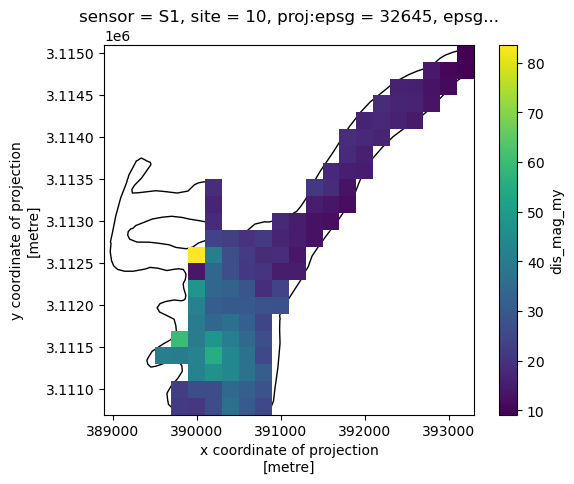

In [113]:
fig, ax = plt.subplots()

rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.09492'].plot(ax=ax, facecolor='None')
ds_09492.dis_mag_my.mean(dim='time').plot(ax=ax)

In [114]:
ds_09492 = ds_09492.drop_dims('band')

In [115]:
ds_09492

<xarray.Dataset>
Dimensions:         (time: 81, x: 22, y: 22)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2015-06-14 2015-06-26 ... 2020-12-20
  * x               (x) float64 3.89e+05 3.892e+05 ... 3.93e+05 3.932e+05
  * y               (y) float64 3.115e+06 3.115e+06 ... 3.111e+06 3.111e+06
    id              (time) <U19 '10_085_017_20150614' ... '10_085_038_20201220'
    orbit           (time) <U3 '017' '017' '017' '017' ... '038' '038' '038'
    sensor          <U2 'S1'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2015-06-08T12:21:45 ... 2020-12-14T...
    img2_date       (time) datetime64[ns] 2015-06-20T12:21:45 ... 2020-12-26T...
    img_separation  (time) float64 -12.0 -12.0 -13.0 -13.0 ... -12.0 -24.0 -12.0
    spatial_ref     int64 0
    crs             int64 0
Data variables:
    dis_ang         (time, y, x) float64 dask.array<chunksize=(1, 22, 22), meta=np.ndarray>
    dis_az          (time, y, x) float64 dask.array<chunksize=(1, 22, 22), meta=np.ndarray>
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 22, 22), meta=np.ndarray>
    dis_N_ang       (time, y, x) float64 dask.array<chunksize=(1, 22, 22), meta=np.ndarray>
    dis_r           (time, y, x) float64 dask.array<chunksize=(1, 22, 22), meta=np.ndarray>
    cov             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dis_mag_my      (time, y, x) float64 dask.array<chunksize=(1, 22, 22), meta=np.ndarray>
    z0              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z1              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z2              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z3              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [1]:
!pwd

/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/notebooks


In [129]:
ds_09492['sem_mag1'] = ds_09492.dis_mag_my.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')


In [117]:
ds_09492['sem_mag2'] = (('time'), [calc_sem(ds_09492.isel(time=t).dis_mag.data) for t in range(len(ds_09492.time))])

In [130]:
ds_09492[['sem_mag1','sem_mag2']]

<xarray.Dataset>
Dimensions:         (time: 81)
Coordinates: (12/16)
  * time            (time) datetime64[ns] 2015-06-14 2015-06-26 ... 2020-12-20
    id              (time) <U19 '10_085_017_20150614' ... '10_085_038_20201220'
    orbit           (time) <U3 '017' '017' '017' '017' ... '038' '038' '038'
    sensor          <U2 'S1'
    frame           (time) <U3 '085' '085' '085' '085' ... '085' '085' '085'
    tile            (time) <U10 '10_085_017' '10_085_017' ... '10_085_038'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2015-06-08T12:21:45 ... 2020-12-14T...
    img2_date       (time) datetime64[ns] 2015-06-20T12:21:45 ... 2020-12-26T...
    img_separation  (time) float64 -12.0 -12.0 -13.0 -13.0 ... -12.0 -24.0 -12.0
    spatial_ref     int64 0
    crs             int64 0
Data variables:
    sem_mag1        (time) float64 2.207 1.808 2.221 4.055 ... 2.209 1.261 2.38
    sem_mag2        (time) float64 2.207 1.808 2.221 4.055 ... 2.209 1.261 2.38
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [131]:
ds_09492.isel(time=1).dis_mag_my.load().stack(xy=('x','y')).dropna(dim='xy')

<xarray.DataArray 'dis_mag_my' (xy: 57)>
array([28.16095006, 51.1365661 , 39.47212767, 48.17478925, 13.42588423,
       46.05863996, 24.56448887, 36.21677946, 28.01925249,  4.8540784 ,
       14.4677332 ,  9.52203002, 24.53455575, 24.48155344, 27.40985371,
       10.94420526, 13.31113517, 29.31737676, 48.13599341, 24.2205558 ,
       58.34167168, 34.75680098, 52.78320029, 34.94393803, 11.77612266,
       42.53310233, 19.3215077 , 25.52223168, 18.38392017, 23.75841044,
        5.36196952, 25.52517414, 21.09857952,  8.88811937, 17.83299254,
        4.39585994,  4.25371129,  6.79812654,  3.9693912 ,  4.0739127 ,
        7.16997216,  4.31506337, 13.74982109, 19.99368662, 20.72872726,
       22.47602778, 18.80142285, 17.77116694, 20.11117281, 22.07499553,
       12.57781595, 21.76625093, 13.53480684, 12.20670458, 19.17448271,
       14.59352735, 13.46135961])
Coordinates: (12/19)
    time            datetime64[ns] 2015-06-26
    id              <U19 '10_085_017_20150626'
    orbit           <U3 '017'
    sensor          <U2 'S1'
    frame           <U3 '085'
    tile            <U10 '10_085_017'
    ...              ...
    img_separation  float64 -12.0
    spatial_ref     int64 0
    crs             int64 0
  * xy              (xy) object MultiIndex
  * x               (xy) float64 3.898e+05 3.898e+05 ... 3.932e+05 3.932e+05
  * y               (xy) float64 3.111e+06 3.111e+06 ... 3.115e+06 3.115e+06

In [132]:
sem2_arr = np.array([  0.03998227, 0.03445977, 0.03344303, 0.03688044,
             0.05679103,  0.04868813, 0.05963356,0.05253283,
             0.03767074, 0.06157816, 0.0550991 , 0.03708166,
        0.10814282,  0.07715329,
        0.13198572, 0.07676508, 0.07509549, 0.06635769, 0.09573682,
              0.14010018,
              0.01329884, 0.02998412,  0.03226335,
           ])

sem3_arr = np.array([28.16095006, 51.1365661 , 39.47212767, 48.17478925, 13.42588423,
       46.05863996, 24.56448887, 36.21677946, 28.01925249,  4.8540784 ,
       14.4677332 ,  9.52203002, 24.53455575, 24.48155344, 27.40985371,
       10.94420526, 13.31113517, 29.31737676, 48.13599341, 24.2205558 ,
       58.34167168, 34.75680098, 52.78320029, 34.94393803, 11.77612266,
       42.53310233, 19.3215077 , 25.52223168, 18.38392017, 23.75841044,
        5.36196952, 25.52517414, 21.09857952,  8.88811937, 17.83299254,
        4.39585994,  4.25371129,  6.79812654,  3.9693912 ,  4.0739127 ,
        7.16997216,  4.31506337, 13.74982109, 19.99368662, 20.72872726,
       22.47602778, 18.80142285, 17.77116694, 20.11117281, 22.07499553,
       12.57781595, 21.76625093, 13.53480684, 12.20670458, 19.17448271,
       14.59352735, 13.46135961])

In [136]:
len(sem3_arr)
np.std(sem3_arr)/np.sqrt(len(sem3_arr))

1.792003706428187

In [135]:
ds_09492.isel(time=1)

<xarray.Dataset>
Dimensions:         (x: 22, y: 22)
Coordinates: (12/18)
    time            datetime64[ns] 2015-06-26
  * x               (x) float64 3.89e+05 3.892e+05 ... 3.93e+05 3.932e+05
  * y               (y) float64 3.115e+06 3.115e+06 ... 3.111e+06 3.111e+06
    id              <U19 '10_085_017_20150626'
    orbit           <U3 '017'
    sensor          <U2 'S1'
    ...              ...
    epsg            int64 32645
    img1_date       datetime64[ns] 2015-06-20T12:21:45
    img2_date       datetime64[ns] 2015-07-02T12:21:45
    img_separation  float64 -12.0
    spatial_ref     int64 0
    crs             int64 0
Data variables: (12/13)
    dis_ang         (y, x) float64 dask.array<chunksize=(22, 22), meta=np.ndarray>
    dis_az          (y, x) float64 dask.array<chunksize=(22, 22), meta=np.ndarray>
    dis_mag         (y, x) float64 dask.array<chunksize=(22, 22), meta=np.ndarray>
    dis_N_ang       (y, x) float64 dask.array<chunksize=(22, 22), meta=np.ndarray>
    dis_r           (y, x) float64 dask.array<chunksize=(22, 22), meta=np.ndarray>
    cov             float64 dask.array<chunksize=(), meta=np.ndarray>
    ...              ...
    z0              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z1              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z2              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z3              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    sem_mag1        float64 1.808
    sem_mag2        float64 1.808
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [34]:
ds_09361 = clip_glacier_add_dem('RGI60-15.09361', rgi_lakes, cube, nasadem_prj, 'full')
#def clip_glacier_add_dem(rgi_id, rgi_outline_df, retreat_xr, dem_xr, output='full'): #all in local utm


retreat clipped
cov done
dem clipped
z stuff


    #retreat_clip_ds['sem_mag'] = (('time'), [calc_sem(retreat_clip_ds.isel(time=t).dis_mag.data) for t in range(len(retreat_clip_ds.time))])


In [63]:
ds_09361 = ds_09361.drop_dims('band')

In [64]:
ds_09361

<xarray.Dataset>
Dimensions:         (time: 240, x: 36, y: 42)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x               (x) float64 3.428e+05 3.43e+05 ... 3.496e+05 3.498e+05
  * y               (y) float64 3.169e+06 3.169e+06 ... 3.161e+06 3.161e+06
    id              (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    orbit           (time) <U3 '002' '001' '010' '002' ... '085' '085' '085'
    sensor          <U2 'S1'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T...
    img_separation  (time) float64 -24.0 -24.0 -24.0 -24.0 ... -13.0 -12.0 -12.0
    spatial_ref     int64 0
    crs             int64 0
Data variables:
    dis_ang         (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_az          (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_N_ang       (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_r           (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    cov             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z0              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z1              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z2              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z3              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    sem_mag         (time) float64 0.7892 0.5638 0.4726 ... 0.5799 0.5548 0.7343
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [75]:
import scipy
test = ds_09361.dis_mag.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')


In [77]:
test.isel(time=1)

<xarray.DataArray 'dis_mag' ()>
array(0.00154466)
Coordinates: (12/16)
    time            datetime64[ns] 2014-10-31
    id              <U19 '10_019_001_20141031'
    orbit           <U3 '001'
    sensor          <U2 'S1'
    frame           <U3 '019'
    tile            <U10 '10_019_001'
    ...              ...
    epsg            int64 32645
    img1_date       datetime64[ns] 2014-10-19T00:18:54
    img2_date       datetime64[ns] 2014-11-12T00:18:54
    img_separation  float64 -24.0
    spatial_ref     int64 0
    crs             int64 0

In [80]:
ds_09361.isel(time=1).dis_mag.load()

<xarray.DataArray 'dis_mag' (y: 42, x: 36)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates: (12/18)
    time            datetime64[ns] 2014-10-31
  * x               (x) float64 3.428e+05 3.43e+05 ... 3.496e+05 3.498e+05
  * y               (y) float64 3.169e+06 3.169e+06 ... 3.161e+06 3.161e+06
    id              <U19 '10_019_001_20141031'
    orbit           <U3 '001'
    sensor          <U2 'S1'
    ...              ...
    epsg            int64 32645
    img1_date       datetime64[ns] 2014-10-19T00:18:54
    img2_date       datetime64[ns] 2014-11-12T00:18:54
    img_separation  float64 -24.0
    spatial_ref     int64 0
    crs             int64 0

In [53]:
ds_09361['sem_mag'] = (('time'), [calc_sem(ds_09361.isel(time=t).dis_mag.data) for t in range(len(ds_09361.time))])

In [55]:
ds_09361.isel(time=1).sem_mag

<xarray.DataArray 'sem_mag' ()>
array(0.56380192)
Coordinates: (12/16)
    time            datetime64[ns] 2014-10-31
    id              <U19 '10_019_001_20141031'
    orbit           <U3 '001'
    sensor          <U2 'S1'
    frame           <U3 '019'
    tile            <U10 '10_019_001'
    ...              ...
    epsg            int64 32645
    img1_date       datetime64[ns] 2014-10-19T00:18:54
    img2_date       datetime64[ns] 2014-11-12T00:18:54
    img_separation  float64 -24.0
    spatial_ref     int64 0
    crs             int64 0

In [59]:
sem((ds_09361.isel(time=1).dis_mag.data*365).flatten(), nan_policy='omit')

0.5638019225332174

In [41]:
sem(ds_09361.isel(time=1).dis_mag.data.flatten(), nan_policy='omit')*365

0.5638019225332173

In [42]:
ds_09361.isel(time=1).dis_mag.mean().compute()*365

<xarray.DataArray 'dis_mag' ()>
array(19.07319009)
Coordinates: (12/16)
    time            datetime64[ns] 2014-10-31
    id              <U19 '10_019_001_20141031'
    orbit           <U3 '001'
    sensor          <U2 'S1'
    frame           <U3 '019'
    tile            <U10 '10_019_001'
    ...              ...
    epsg            int64 32645
    img1_date       datetime64[ns] 2014-10-19T00:18:54
    img2_date       datetime64[ns] 2014-11-12T00:18:54
    img_separation  float64 -24.0
    spatial_ref     int64 0
    crs             int64 0

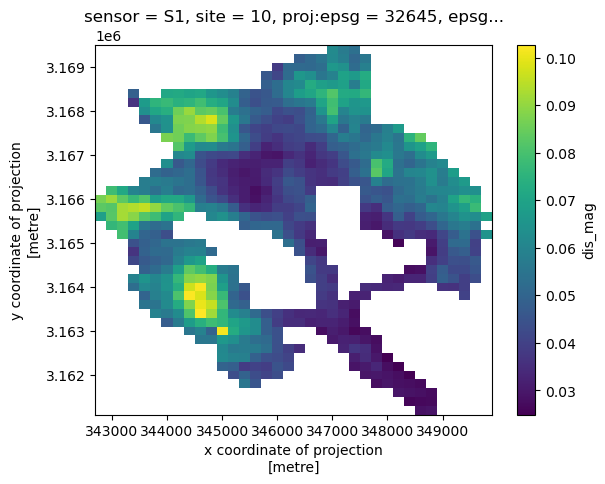

In [47]:
ds_09361.dis_mag.mean(dim='time').plot()

In [52]:
ds_09361

<xarray.Dataset>
Dimensions:         (time: 240, x: 36, y: 42, band: 5)
Coordinates: (12/19)
  * time            (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x               (x) float64 3.428e+05 3.43e+05 ... 3.496e+05 3.498e+05
  * y               (y) float64 3.169e+06 3.169e+06 ... 3.161e+06 3.161e+06
    id              (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    orbit           (time) <U3 '002' '001' '010' '002' ... '085' '085' '085'
    sensor          <U2 'S1'
    ...              ...
    epsg            int64 32645
    img1_date       (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T...
    img2_date       (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T...
    img_separation  (time) float64 -24.0 -24.0 -24.0 -24.0 ... -13.0 -12.0 -12.0
    spatial_ref     int64 0
    crs             int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang         (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_az          (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_mag         (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_N_ang       (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    dis_r           (time, y, x) float64 dask.array<chunksize=(1, 42, 36), meta=np.ndarray>
    cov             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z0              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z1              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z2              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z3              (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

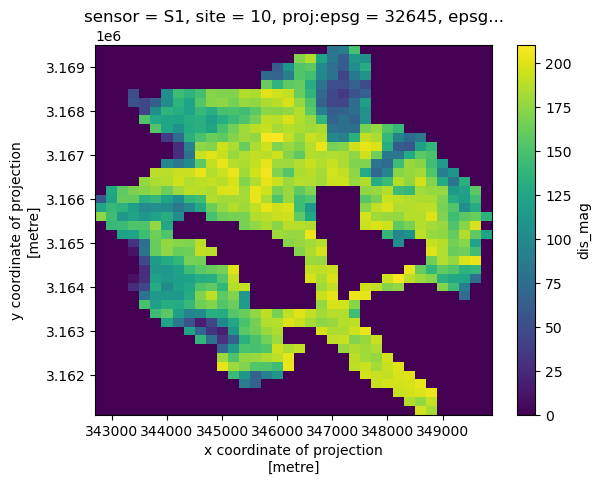

In [51]:
#    valid_pixels = retreat_clip_ds.dis_mag.count(dim=['x','y'])


ds_09361.dis_mag.count(dim='time').plot()

(array([ 60., 113.,  95.,  62.,  51.,  33.,  23.,   6.,   9.,   7.]),
 array([0.00232138, 0.01852107, 0.03472076, 0.05092046, 0.06712015,
        0.08331984, 0.09951954, 0.11571923, 0.13191892, 0.14811861,
        0.16431831]),
 <BarContainer object of 10 artists>)

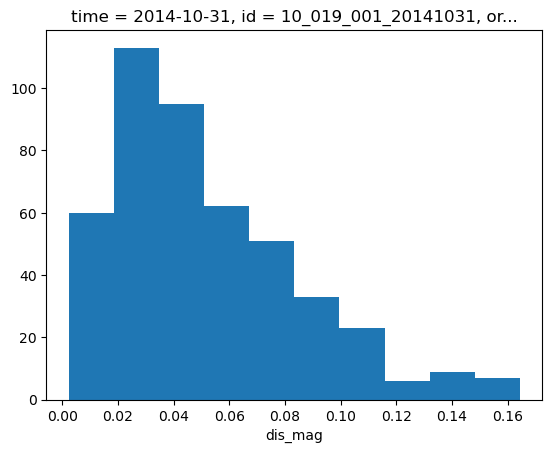

In [43]:
xr.plot.hist(ds_09361.isel(time=1).dis_mag)

In [ ]:
#def clip_glacier_add_dem(rgi_id, rgi_outline_df, retreat_xr, dem_xr, output='full'): #all in local utm
#wrapper_single_glacier('RGI60-15.09361', rgi_lakes, cube, nasadem_prj, 'dis_mag')



In [ ]:
ds_09361

In [ ]:
df_lakes = pd.concat([wrapper_single_glacier(rgi_id, rgi_lakes, cube, nasadem_prj, 'dis_mag') for rgi_id in lake_ids])

retreat clipped
cov done
dem clipped


In [ ]:
df_lands = pd.concat([wrapper_single_glacier(rgi_id, rgi_lands, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids])